,Description,Value
0,Session id,123
1,Target,cnt
2,Target type,Regression
3,Original data shape,"(17379, 20)"
4,Transformed data shape,"(17379, 66)"
5,Transformed train set shape,"(12165, 66)"
6,Transformed test set shape,"(5214, 66)"
7,Numeric features,7
8,Categorical features,12
9,Preprocess,True


Comparing Models...


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,28.4531,2268.8278,47.4628,0.9305,0.4001,0.3973,9.3890
lightgbm,Light Gradient Boosting Machine,32.0331,2330.3179,48.2178,0.9286,0.5458,0.6594,0.6970
xgboost,Extreme Gradient Boosting,31.8967,2372.2608,48.6284,0.9274,0.5536,0.6478,0.7430
rf,Random Forest Regressor,33.9830,2917.9342,53.9177,0.9106,0.4983,0.5962,9.4090
dt,Decision Tree Regressor,45.1588,5854.0169,76.3450,0.8206,0.5984,0.6098,0.4090
knn,K Neighbors Regressor,50.1266,5894.0714,76.6940,0.8193,0.4974,0.5524,0.4560
gbr,Gradient Boosting Regressor,58.9142,6740.2186,82.0484,0.7934,0.8016,1.4517,1.8870
ridge,Ridge Regression,74.1140,10141.6410,100.6653,0.6892,1.0115,2.6992,0.4610
br,Bayesian Ridge,74.1262,10141.6991,100.6660,0.6892,1.0118,2.7009,0.3500
llar,Lasso Least Angle Regression,74.0947,10213.9631,101.0274,0.6869,1.0080,2.6518,0.3450


Processing:   0%|          | 0/79 [00:00<?, ?it/s]


Best Model Results:
                                    Model           MAE           MSE  \
et                  Extra Trees Regressor  2.845310e+01  2.268828e+03   
lightgbm  Light Gradient Boosting Machine  3.203310e+01  2.330318e+03   
xgboost         Extreme Gradient Boosting  3.189670e+01  2.372261e+03   
rf                Random Forest Regressor  3.398300e+01  2.917934e+03   
dt                Decision Tree Regressor  4.515880e+01  5.854017e+03   
knn                 K Neighbors Regressor  5.012660e+01  5.894071e+03   
gbr           Gradient Boosting Regressor  5.891420e+01  6.740219e+03   
ridge                    Ridge Regression  7.411400e+01  1.014164e+04   
br                         Bayesian Ridge  7.412620e+01  1.014170e+04   
llar         Lasso Least Angle Regression  7.409470e+01  1.021396e+04   
lasso                    Lasso Regression  7.409520e+01  1.021395e+04   
huber                     Huber Regressor  7.128110e+01  1.056530e+04   
en                            

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,28.0759,2213.7583,47.0506,0.9337,0.3803,0.3710



Sample predictions with accuracy:
       cnt  prediction_label  prediction_diff_Percentage
5792   295            284.62                        3.52
7823   313            425.85                       36.05
15426   84             90.97                        8.30
15028  276            291.00                        5.43
12290  402            393.48                        2.12

Mean prediction difference: 37.10%


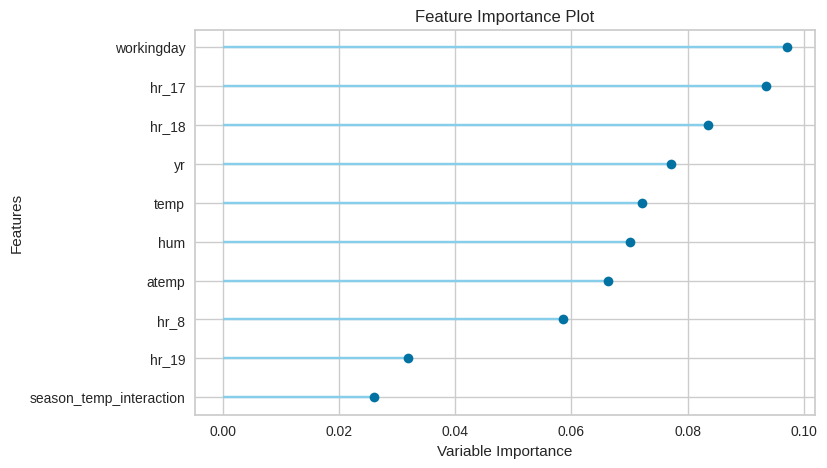


Saving the model...
Transformation Pipeline and Model Successfully Saved


In [5]:
# Regression model for Bike Dataset for Hours by Omar Al-Dulaimi

#Two IMPORTANT steps required for this to run, please add the Bike dataset in the files of Colab, and Also run !pip install pycaret

#Please uncomment the line below FIRST, you need to have the library first
#!pip install pycaret

# Import required libraries
from pycaret.regression import *
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#I created extra variables that is correlated with existing variables, like for example if hours is 0-5 then its early morning, if its after 8 then its rush hour
# and so on, using these correlated variables and existing variables from dataset the model makes predictions and calculations

def create_improved_features(df):
    """
    Create enhanced features based on analysis findings
    """
    # 1. Time-based features
    df['is_early_morning'] = df['hr'].isin(['2', '3', '4', '5']).astype(int)
    df['is_rush_hour'] = df['hr'].isin(['8', '9', '17', '18']).astype(int)

    # 2. Volume-based features
    df['is_weekend'] = (df['weekday'].isin(['6', '0'])).astype(int)
    df['is_holiday_weekend'] = ((df['holiday'] == '1') & (df['weekday'].isin(['6', '0']))).astype(int)

    # 3. Weather interaction features
    df['temp_humidity_interaction'] = df['temp'] * df['hum']
    df['weather_temp_interaction'] = df['temp'] * pd.to_numeric(df['weathersit'])

    # 4. Season-weather interactions
    df['season_temp_interaction'] = pd.to_numeric(df['season']) * df['temp']

    return df

# Load the dataset and remove unamed columns
df = pd.read_csv('hour.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]


# Create the new dataset with correlated variables using the function that I created with Bike dataset
df = create_improved_features(df)


# Seperate categories and numerical features according to professor's requirements from video
categorical_features = ['season', 'yr', 'mnth', 'hr', 'holiday',
                       'weekday', 'workingday', 'weathersit',
                       'is_early_morning', 'is_rush_hour',
                       'is_weekend', 'is_holiday_weekend']

numeric_features = ['temp', 'atemp', 'hum', 'windspeed',
                   'temp_humidity_interaction', 'weather_temp_interaction',
                   'season_temp_interaction']

for col in categorical_features:
    df[col] = df[col].astype(str)

# Initialize setup
s = setup(
    data=df,
    target='cnt',
    categorical_features=categorical_features,
    numeric_features=numeric_features,
    normalize=True,
    transformation=False,
    session_id=123,

)

# Compare models
print("Comparing Models...")
best_models = compare_models(
    n_select=3,
    exclude=['tr']
)

# Get the best model
best_model = best_models[0]
print("\nBest Model Results:")
print(pull())

# Create predictions on test set
print("\nGenerating predictions on test set...")
predictions = predict_model(best_model)

# Add percentage difference calculation with new column name
predictions['prediction_diff_Percentage'] = abs(predictions['prediction_label'] - predictions['cnt']) / predictions['cnt'] * 100
predictions['prediction_diff_Percentage'] = predictions['prediction_diff_Percentage'].round(2)

print("\nSample predictions with accuracy:")
print(predictions[['cnt', 'prediction_label', 'prediction_diff_Percentage']].head())
print("\nMean prediction difference: {:.2f}%".format(predictions['prediction_diff_Percentage'].mean()))

# Plot feature importance
plot_model(best_model, plot='feature')

# Save the model
print("\nSaving the model...")
save_model(best_model, 'improved_bike_rental_model')

# Create a simple prediction function for new data
def predict_rentals(new_data):
    """
    Make predictions on new data
    Parameters:
        new_data: pandas DataFrame with the same features as training data
    Returns:
        DataFrame with predictions and accuracy
    """
    # Create the same features for new data
    new_data = create_improved_features(new_data)

    preds = predict_model(best_model, data=new_data)
    preds['prediction_diff_Percentage'] = abs(preds['prediction_label'] - preds['cnt']) / preds['cnt'] * 100
    preds['prediction_diff_Percentage'] = preds['prediction_diff_Percentage'].round(2)
    return preds

  #Also I compared the predicted vs actual rented bike cnt, the estimated accuracy of model is 64% which is the highest i am able to achieve
  # using the PyCaret Regression Tutorial and all the notes within it.